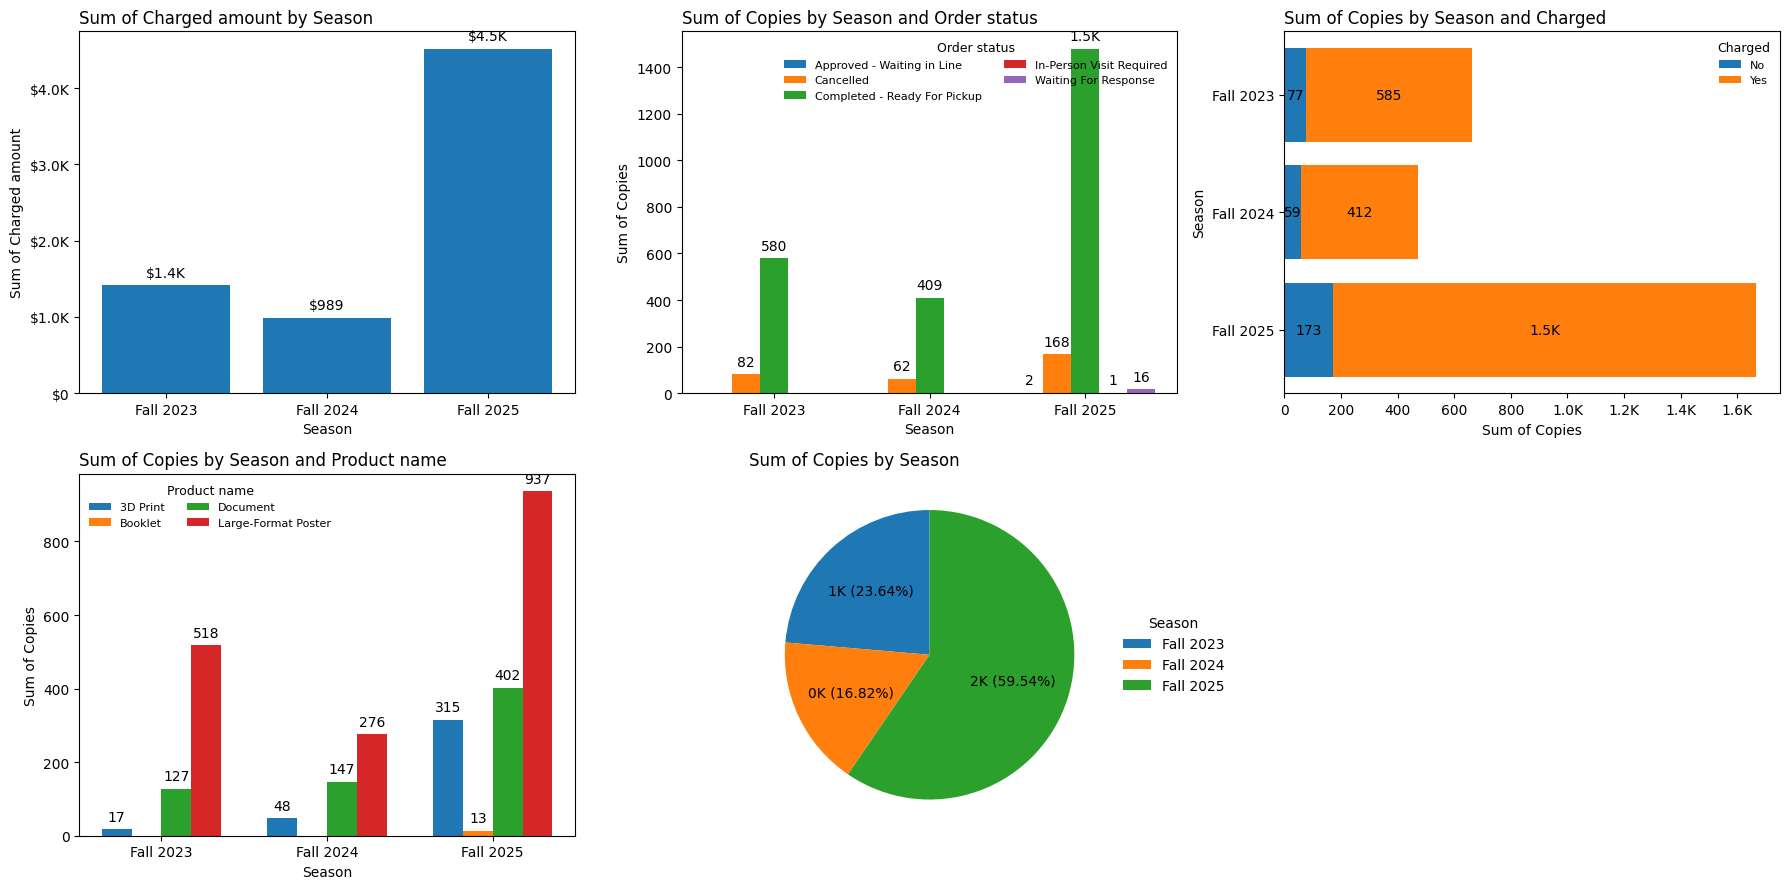

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

FILE_PATH = "Copy of Papercut_orders-Fall_2023_2024_2025_merged.xlsx"
SHEET_NAME = "All_Fall"

# ---------------- helpers ----------------
def clean_currency(series: pd.Series) -> pd.Series:
    s = (series.astype(str)
         .str.replace("$", "", regex=False)
         .str.replace(",", "", regex=False)
         .str.strip())
    return pd.to_numeric(s, errors="coerce")

def fmt_k(x):
    x = float(x)
    if abs(x) >= 1000:
        return f"{x/1000:.1f}K"
    return f"{int(x)}"

def fmt_money_k(x):
    x = float(x)
    if abs(x) >= 1000:
        return f"${x/1000:.1f}K"
    return f"${x:.0f}"

def label_bars_vertical(ax, money=False):
    for r in ax.patches:
        val = r.get_height()
        if val == 0:
            continue
        txt = fmt_money_k(val) if money else fmt_k(val)
        ax.annotate(
            txt,
            (r.get_x() + r.get_width()/2, val),
            ha="center", va="bottom",
            xytext=(0, 4), textcoords="offset points"
        )

def label_grouped_vertical(ax, money=False):
    # labels each patch (works for grouped bar charts)
    for r in ax.patches:
        val = r.get_height()
        if val == 0:
            continue
        txt = fmt_money_k(val) if money else fmt_k(val)
        ax.annotate(
            txt,
            (r.get_x() + r.get_width()/2, val),
            ha="center", va="bottom",
            xytext=(0, 4), textcoords="offset points"
        )

def stacked_barh_with_labels(ax, index_labels, series_list, series_names):
    """
    Draw stacked horizontal bars for multiple series on the same y,
    and label each segment.
    """
    left = np.zeros(len(index_labels))
    y = np.arange(len(index_labels))

    for vals, name in zip(series_list, series_names):
        bars = ax.barh(y, vals, left=left, label=name)
        for b, v, lft in zip(bars, vals, left):
            if v == 0:
                continue
            # label inside if enough width, else just after
            x_text = lft + v/2
            ax.text(x_text, b.get_y() + b.get_height()/2, fmt_k(v),
                    ha="center", va="center")
        left += np.array(vals)

    ax.set_yticks(y)
    ax.set_yticklabels(index_labels)
    ax.invert_yaxis()  # top to bottom like Power BI

# ---------------- load + clean ----------------
df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)

need = ["Season", "Copies", "Charged amount", "Order status", "Charged", "Product name"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in file: {missing}")

df["Copies"] = pd.to_numeric(df["Copies"], errors="coerce").fillna(0)
df["Charged amount"] = clean_currency(df["Charged amount"]).fillna(0)

# Season order (Fall 2023, Fall 2024, Fall 2025)
def season_year(s):
    try:
        return int(str(s).split()[-1])
    except:
        return 0

seasons = sorted(df["Season"].dropna().unique(), key=season_year)

# ---------------- aggregates ----------------
charged_by_season = df.groupby("Season")["Charged amount"].sum().reindex(seasons, fill_value=0)

copies_by_season_status = (
    df.groupby(["Season", "Order status"])["Copies"].sum()
      .unstack(fill_value=0)
      .reindex(seasons, fill_value=0)
)

copies_by_season_charged = (
    df.groupby(["Season", "Charged"])["Copies"].sum()
      .unstack(fill_value=0)
      .reindex(seasons, fill_value=0)
)

copies_by_season_product = (
    df.groupby(["Season", "Product name"])["Copies"].sum()
      .unstack(fill_value=0)
      .reindex(seasons, fill_value=0)
)

copies_by_season = df.groupby("Season")["Copies"].sum().reindex(seasons, fill_value=0)

# Keep nice ordering like Power BI (optional)
# Order status: pick most important ones first if present
preferred_status = [
    "Approved - Waiting in Line",
    "Cancelled",
    "Completed - Ready For Pickup",
    "In-Person Visit Required",
    "Waiting For Response",
]
status_cols = [s for s in preferred_status if s in copies_by_season_status.columns]
status_cols += [s for s in copies_by_season_status.columns if s not in status_cols]
copies_by_season_status = copies_by_season_status[status_cols]

# Product order
preferred_products = ["3D Print", "Booklet", "Document", "Large-Format Poster"]
prod_cols = [p for p in preferred_products if p in copies_by_season_product.columns]
prod_cols += [p for p in copies_by_season_product.columns if p not in prod_cols]
copies_by_season_product = copies_by_season_product[prod_cols]

# Charged order
charged_cols = ["No", "Yes"]
charged_cols = [c for c in charged_cols if c in copies_by_season_charged.columns]
charged_cols += [c for c in copies_by_season_charged.columns if c not in charged_cols]
copies_by_season_charged = copies_by_season_charged[charged_cols]

# ---------------- dashboard layout (like screenshot) ----------------
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
ax1, ax2, ax3 = axes[0]
ax4, ax5, ax6 = axes[1]

# 1) Sum of Charged amount by Season (vertical bars)
ax1.bar(charged_by_season.index, charged_by_season.values)
ax1.set_title("Sum of Charged amount by Season", loc="left")
ax1.set_xlabel("Season")
ax1.set_ylabel("Sum of Charged amount")
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_money_k(x)))
label_bars_vertical(ax1, money=True)

# 2) Sum of Copies by Season and Order status (grouped columns)
x = np.arange(len(seasons))
n = len(copies_by_season_status.columns)
width = 0.12 if n > 5 else 0.18

for i, col in enumerate(copies_by_season_status.columns):
    ax2.bar(x + (i - (n-1)/2)*width, copies_by_season_status[col].values, width=width, label=col)

ax2.set_title("Sum of Copies by Season and Order status", loc="left")
ax2.set_xlabel("Season")
ax2.set_ylabel("Sum of Copies")
ax2.set_xticks(x)
ax2.set_xticklabels(seasons)
label_grouped_vertical(ax2)
ax2.legend(title="Order status", fontsize=8, title_fontsize=9, ncols=2, frameon=False)

# 3) Sum of Copies by Season and Charged (stacked horizontal)
ax3.set_title("Sum of Copies by Season and Charged", loc="left")
ax3.set_xlabel("Sum of Copies")
ax3.set_ylabel("Season")
stacked_barh_with_labels(
    ax3,
    index_labels=seasons,
    series_list=[copies_by_season_charged[c].values for c in copies_by_season_charged.columns],
    series_names=list(copies_by_season_charged.columns)
)
ax3.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_k(x)))
ax3.legend(title="Charged", fontsize=8, title_fontsize=9, frameon=False)

# 4) Sum of Copies by Season and Product name (grouped columns)
x2 = np.arange(len(seasons))
n2 = len(copies_by_season_product.columns)
width2 = 0.12 if n2 > 5 else 0.18

for i, col in enumerate(copies_by_season_product.columns):
    ax4.bar(x2 + (i - (n2-1)/2)*width2, copies_by_season_product[col].values, width=width2, label=col)

ax4.set_title("Sum of Copies by Season and Product name", loc="left")
ax4.set_xlabel("Season")
ax4.set_ylabel("Sum of Copies")
ax4.set_xticks(x2)
ax4.set_xticklabels(seasons)
label_grouped_vertical(ax4)
ax4.legend(title="Product name", fontsize=8, title_fontsize=9, ncols=2, frameon=False)

# 5) Sum of Copies by Season (pie)
ax5.set_title("Sum of Copies by Season", loc="left")

vals = copies_by_season.values
labels = copies_by_season.index.tolist()

def pie_label(pct):
    total = vals.sum()
    value = pct * total / 100.0
    # match your screenshot style like "2K (59.54%)"
    return f"{value/1000:.0f}K ({pct:.2f}%)"

ax5.pie(vals, labels=None, autopct=pie_label, startangle=90)
ax5.legend(labels, title="Season", loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False)

# empty last panel (matches screenshot blank area)
ax6.axis("off")

plt.tight_layout()
plt.show()


C:\Users\vbhav\AppData\Local\Temp\ipykernel_14400\3390590792.py:250: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.92])


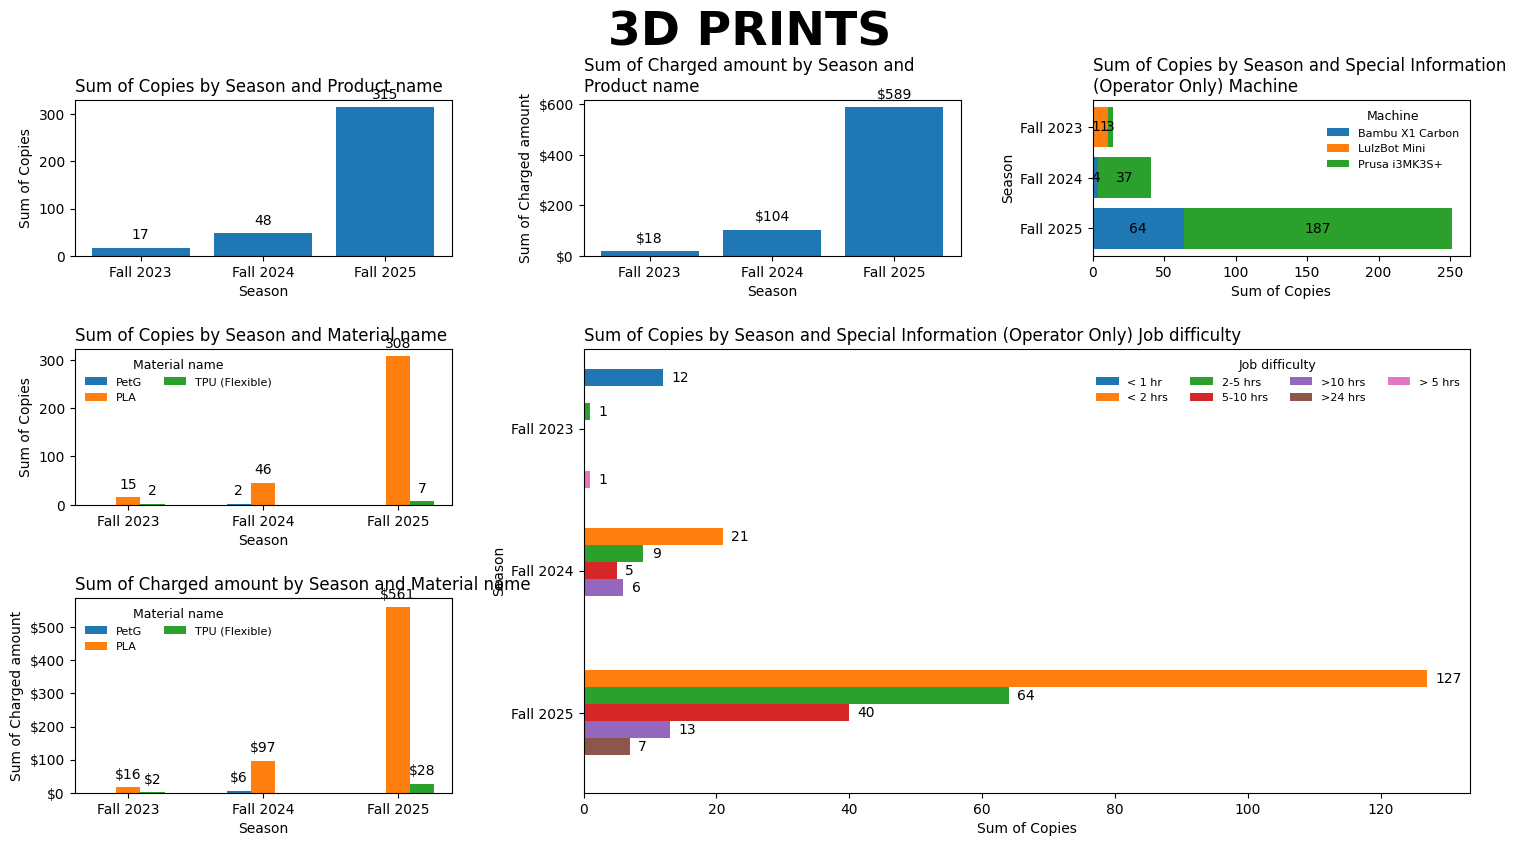

In [3]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

FILE_PATH = "Copy of Papercut_orders-Fall_2023_2024_2025_merged.xlsx"
SHEET_NAME = "All_Fall"
PRODUCT = "3D Print"

# ---------- helpers ----------
def clean_currency(series: pd.Series) -> pd.Series:
    s = (series.astype(str)
         .str.replace("$", "", regex=False)
         .str.replace(",", "", regex=False)
         .str.strip())
    return pd.to_numeric(s, errors="coerce")

def season_year(s):
    try:
        return int(str(s).split()[-1])
    except:
        return 0

def fmt_k(x):
    x = float(x)
    return f"{int(x)}" if abs(x) < 1000 else f"{x/1000:.1f}K"

def fmt_money(x):
    x = float(x)
    return f"${x:,.0f}" if abs(x) < 1000 else f"${x/1000:.1f}K"

def label_bars_vertical(ax, money=False):
    for r in ax.patches:
        h = r.get_height()
        if h == 0:
            continue
        txt = fmt_money(h) if money else fmt_k(h)
        ax.annotate(
            txt,
            (r.get_x() + r.get_width()/2, h),
            ha="center", va="bottom",
            xytext=(0, 4), textcoords="offset points"
        )

def label_grouped_vertical(ax, money=False):
    # works for grouped column charts too
    for r in ax.patches:
        h = r.get_height()
        if h == 0:
            continue
        txt = fmt_money(h) if money else fmt_k(h)
        ax.annotate(
            txt,
            (r.get_x() + r.get_width()/2, h),
            ha="center", va="bottom",
            xytext=(0, 4), textcoords="offset points"
        )

def label_stacked_barh(ax, values_matrix, y_positions):
    """
    values_matrix: list of arrays (each array is one stack series across y)
    Adds labels centered in each non-zero segment.
    """
    left = np.zeros(len(y_positions))
    for vals in values_matrix:
        for i, v in enumerate(vals):
            if v == 0:
                continue
            ax.text(left[i] + v/2, y_positions[i], f"{int(v)}", ha="center", va="center")
        left += np.array(vals)

# ---------- load + clean ----------
df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)

need = [
    "Season", "Product name", "Copies", "Charged amount",
    "Material name",
    "Special Information (Operator Only) Machine",
    "Special Information (Operator Only) Job difficulty",
]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in file: {missing}")

df["Copies"] = pd.to_numeric(df["Copies"], errors="coerce").fillna(0)
df["Charged amount"] = clean_currency(df["Charged amount"]).fillna(0)

# Filter to 3D Print
d3 = df[df["Product name"].astype(str).str.strip() == PRODUCT].copy()

# Season ordering like Power BI
seasons = sorted(d3["Season"].dropna().unique(), key=season_year)

# ---------- aggregations ----------
# 1) Copies by Season (3D Print only)
copies_by_season = d3.groupby("Season")["Copies"].sum().reindex(seasons, fill_value=0)

# 2) Charged amount by Season (3D Print only)
amt_by_season = d3.groupby("Season")["Charged amount"].sum().reindex(seasons, fill_value=0)

# 3) Copies by Season and Machine (stacked horizontal)
machine_pivot = (
    d3.groupby(["Season", "Special Information (Operator Only) Machine"])["Copies"]
      .sum()
      .unstack(fill_value=0)
      .reindex(seasons, fill_value=0)
)

# 4) Copies by Season and Material (grouped columns)
material_pivot_copies = (
    d3.groupby(["Season", "Material name"])["Copies"]
      .sum()
      .unstack(fill_value=0)
      .reindex(seasons, fill_value=0)
)

# 5) Charged amount by Season and Material (grouped columns)
material_pivot_amt = (
    d3.groupby(["Season", "Material name"])["Charged amount"]
      .sum()
      .unstack(fill_value=0)
      .reindex(seasons, fill_value=0)
)

# 6) Copies by Season and Job difficulty (grouped horizontal)
job_pivot = (
    d3.groupby(["Season", "Special Information (Operator Only) Job difficulty"])["Copies"]
      .sum()
      .unstack(fill_value=0)
      .reindex(seasons, fill_value=0)
)

# ---------- optional preferred ordering (matches your screenshots better) ----------
preferred_materials = ["PetG", "PLA", "TPU (Flexible)", "(Blank)"]
mat_cols = [m for m in preferred_materials if m in material_pivot_copies.columns]
mat_cols += [m for m in material_pivot_copies.columns if m not in mat_cols]
material_pivot_copies = material_pivot_copies[mat_cols]
material_pivot_amt = material_pivot_amt[mat_cols]

preferred_machines = ["Bambu X1 Carbon", "LulzBot Mini", "Prusa i3MK3S+"]
mach_cols = [m for m in preferred_machines if m in machine_pivot.columns]
mach_cols += [m for m in machine_pivot.columns if m not in mach_cols]
machine_pivot = machine_pivot[mach_cols]

preferred_jobs = ["< 1 hr", "< 2 hrs", "2-5 hrs", "5-10 hrs", "5 hrs", ">10 hrs", ">24 hrs"]
job_cols = [j for j in preferred_jobs if j in job_pivot.columns]
job_cols += [j for j in job_pivot.columns if j not in job_cols]
job_pivot = job_pivot[job_cols]

# ---------- dashboard layout (approx like your screenshot) ----------
fig = plt.figure(figsize=(18, 9))
gs = fig.add_gridspec(3, 3, height_ratios=[1.0, 1.0, 1.25], wspace=0.35, hspace=0.55)

# Title
fig.suptitle("3D PRINTS", fontsize=34, fontweight="bold")

# (A) Sum of Copies by Season and Product name (single series)
axA = fig.add_subplot(gs[0, 0])
axA.bar(copies_by_season.index.astype(str), copies_by_season.values)
axA.set_title("Sum of Copies by Season and Product name", loc="left")
axA.set_xlabel("Season")
axA.set_ylabel("Sum of Copies")
label_bars_vertical(axA, money=False)

# (B) Sum of Charged amount by Season and Product name
axB = fig.add_subplot(gs[0, 1])
axB.bar(amt_by_season.index.astype(str), amt_by_season.values)
axB.set_title("Sum of Charged amount by Season and\nProduct name", loc="left")
axB.set_xlabel("Season")
axB.set_ylabel("Sum of Charged amount")
axB.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_money(x)))
label_bars_vertical(axB, money=True)

# (C) Sum of Copies by Season and Machine (stacked horizontal)
axC = fig.add_subplot(gs[0, 2])
y = np.arange(len(seasons))
left = np.zeros(len(seasons))
for col in machine_pivot.columns:
    vals = machine_pivot[col].values
    axC.barh(y, vals, left=left, label=str(col))
    left += vals
label_stacked_barh(axC, [machine_pivot[c].values for c in machine_pivot.columns], y)

axC.set_yticks(y)
axC.set_yticklabels(seasons)
axC.invert_yaxis()
axC.set_title("Sum of Copies by Season and Special Information\n(Operator Only) Machine", loc="left")
axC.set_xlabel("Sum of Copies")
axC.set_ylabel("Season")
axC.legend(title="Machine", fontsize=8, title_fontsize=9, frameon=False)

# (D) Sum of Copies by Season and Material name (grouped columns)
axD = fig.add_subplot(gs[1, 0])
x = np.arange(len(seasons))
n = len(material_pivot_copies.columns)
width = 0.12 if n > 4 else 0.18
for i, col in enumerate(material_pivot_copies.columns):
    axD.bar(x + (i - (n-1)/2)*width, material_pivot_copies[col].values, width=width, label=str(col))
axD.set_title("Sum of Copies by Season and Material name", loc="left")
axD.set_xlabel("Season")
axD.set_ylabel("Sum of Copies")
axD.set_xticks(x)
axD.set_xticklabels(seasons)
label_grouped_vertical(axD, money=False)
axD.legend(title="Material name", fontsize=8, title_fontsize=9, ncols=2, frameon=False)

# (E) Sum of Charged amount by Season and Material name (grouped columns)
axE = fig.add_subplot(gs[2, 0])
x2 = np.arange(len(seasons))
n2 = len(material_pivot_amt.columns)
width2 = 0.12 if n2 > 4 else 0.18
for i, col in enumerate(material_pivot_amt.columns):
    axE.bar(x2 + (i - (n2-1)/2)*width2, material_pivot_amt[col].values, width=width2, label=str(col))
axE.set_title("Sum of Charged amount by Season and Material name", loc="left")
axE.set_xlabel("Season")
axE.set_ylabel("Sum of Charged amount")
axE.set_xticks(x2)
axE.set_xticklabels(seasons)
axE.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_money(x)))
label_grouped_vertical(axE, money=True)
axE.legend(title="Material name", fontsize=8, title_fontsize=9, ncols=2, frameon=False)

# (F) Sum of Copies by Season and Job difficulty (grouped horizontal – big chart)
axF = fig.add_subplot(gs[1:, 1:])
y0 = np.arange(len(seasons))
m = len(job_pivot.columns)
bar_h = 0.12 if m > 6 else 0.18
offsets = np.linspace(-bar_h*(m-1)/2, bar_h*(m-1)/2, m)

for off, col in zip(offsets, job_pivot.columns):
    vals = job_pivot[col].values
    bars = axF.barh(y0 + off, vals, height=bar_h, label=str(col))
    for b, v in zip(bars, vals):
        if v == 0:
            continue
        axF.annotate(f"{int(v)}",
                     (v, b.get_y() + b.get_height()/2),
                     ha="left", va="center",
                     xytext=(6, 0), textcoords="offset points")

axF.set_yticks(y0)
axF.set_yticklabels(seasons)
axF.invert_yaxis()
axF.set_title("Sum of Copies by Season and Special Information (Operator Only) Job difficulty", loc="left")
axF.set_xlabel("Sum of Copies")
axF.set_ylabel("Season")
axF.legend(title="Job difficulty", fontsize=8, title_fontsize=9, ncols=4, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


C:\Users\vbhav\AppData\Local\Temp\ipykernel_14400\2394694571.py:256: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


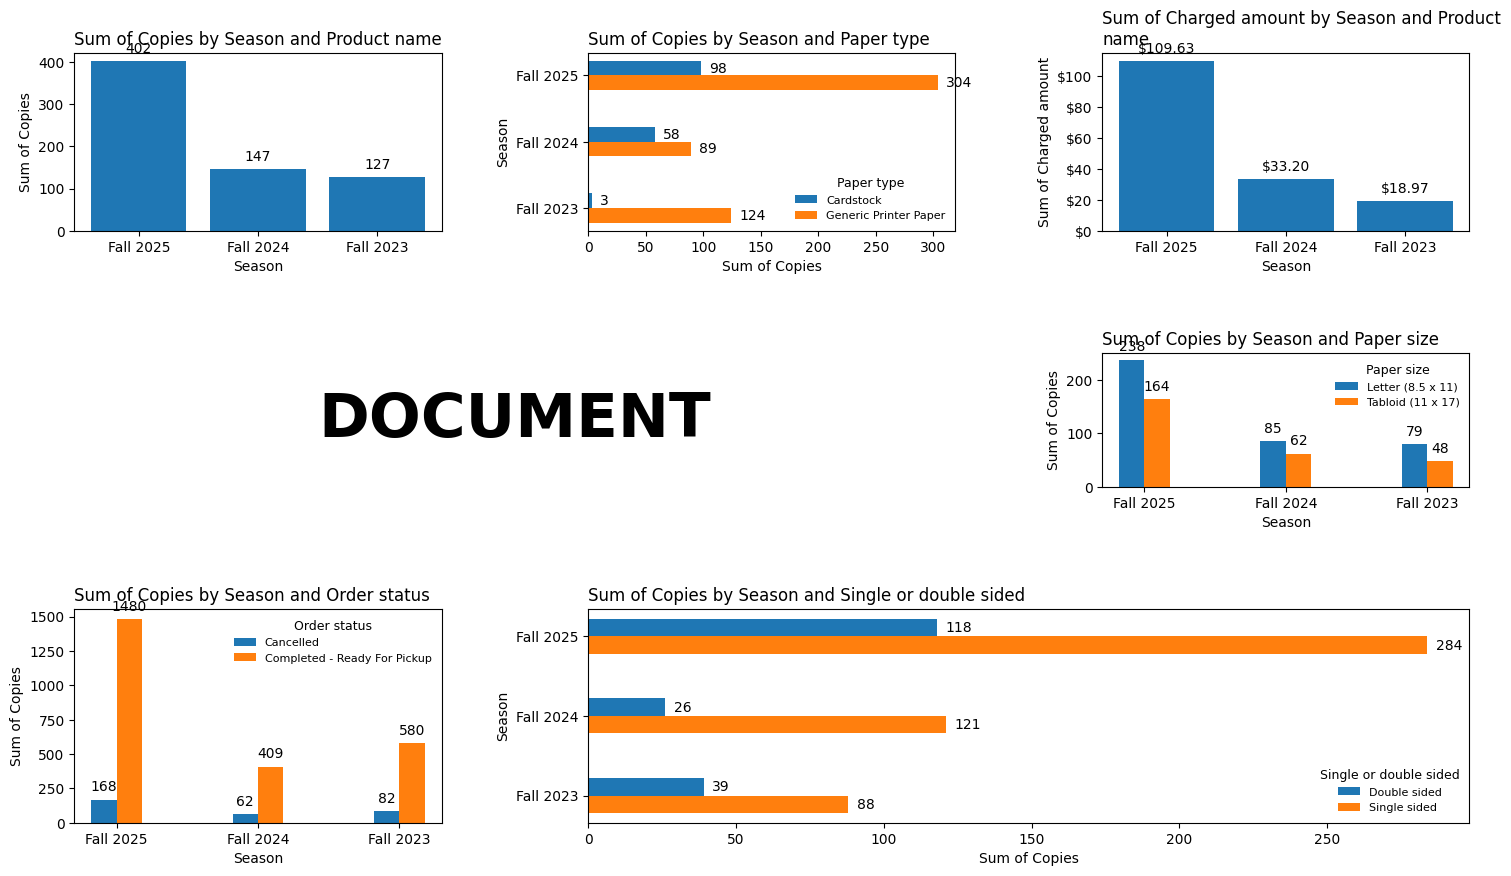

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

FILE_PATH = "Copy of Papercut_orders-Fall_2023_2024_2025_merged.xlsx"
SHEET_NAME = "All_Fall"
PRODUCT = "Document"

# Matches your screenshot: order-status visual appears to be ALL products (not filtered)
ORDER_STATUS_SCOPE = "all"   # change to "document" if you want only Document

# ---------------- helpers ----------------
def clean_currency(series: pd.Series) -> pd.Series:
    s = (series.astype(str)
         .str.replace("$", "", regex=False)
         .str.replace(",", "", regex=False)
         .str.strip())
    return pd.to_numeric(s, errors="coerce")

def season_year(s):
    try:
        return int(str(s).split()[-1])
    except:
        return -1

def fmt_money(x):
    return f"${float(x):.2f}"

def label_bars_vertical(ax, money=False):
    for r in ax.patches:
        h = r.get_height()
        if h == 0:
            continue
        txt = fmt_money(h) if money else f"{int(h)}"
        ax.annotate(
            txt,
            (r.get_x() + r.get_width()/2, h),
            ha="center", va="bottom",
            xytext=(0, 4), textcoords="offset points"
        )

def label_bars_horizontal(ax, money=False):
    for r in ax.patches:
        w = r.get_width()
        if w == 0:
            continue
        txt = fmt_money(w) if money else f"{int(w)}"
        ax.annotate(
            txt,
            (w, r.get_y() + r.get_height()/2),
            ha="left", va="center",
            xytext=(6, 0), textcoords="offset points"
        )

def grouped_barh(ax, pivot_df, title, xlabel, ylabel, legend_title, season_order):
    """
    Grouped horizontal bars (y = season, bars = categories in columns).
    """
    pivot_df = pivot_df.reindex(season_order, fill_value=0)
    seasons = pivot_df.index.astype(str).tolist()
    cols = pivot_df.columns.astype(str).tolist()

    y = np.arange(len(seasons))
    m = len(cols)
    bar_h = 0.14 if m > 2 else 0.22
    offsets = np.linspace(-bar_h*(m-1)/2, bar_h*(m-1)/2, m)

    for off, col in zip(offsets, cols):
        vals = pivot_df[col].values
        bars = ax.barh(y + off, vals, height=bar_h, label=col)
        for b, v in zip(bars, vals):
            if v == 0:
                continue
            ax.annotate(
                f"{int(v)}",
                (v, b.get_y() + b.get_height()/2),
                ha="left", va="center",
                xytext=(6, 0), textcoords="offset points"
            )

    ax.set_yticks(y)
    ax.set_yticklabels(seasons)
    ax.invert_yaxis()
    ax.set_title(title, loc="left")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=legend_title, frameon=False, fontsize=8, title_fontsize=9)

def grouped_barv(ax, pivot_df, title, xlabel, ylabel, legend_title, season_order):
    """
    Grouped vertical bars (x = season, bars = categories in columns).
    """
    pivot_df = pivot_df.reindex(season_order, fill_value=0)
    seasons = pivot_df.index.astype(str).tolist()
    cols = pivot_df.columns.astype(str).tolist()

    x = np.arange(len(seasons))
    m = len(cols)
    width = 0.18 if m <= 2 else 0.12

    for i, col in enumerate(cols):
        vals = pivot_df[col].values
        ax.bar(x + (i - (m-1)/2)*width, vals, width=width, label=col)

    label_bars_vertical(ax, money=False)
    ax.set_xticks(x)
    ax.set_xticklabels(seasons)
    ax.set_title(title, loc="left")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=legend_title, frameon=False, fontsize=8, title_fontsize=9)

# ---------------- load + clean ----------------
df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)

need = ["Season", "Product name", "Copies", "Charged amount",
        "Paper type", "Paper size", "Order status", "Single or double sided"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in file: {missing}")

df["Copies"] = pd.to_numeric(df["Copies"], errors="coerce").fillna(0)
df["Charged amount"] = clean_currency(df["Charged amount"]).fillna(0)

# Filter to Document for document-specific visuals
doc = df[df["Product name"].astype(str).str.strip() == PRODUCT].copy()

# Season order like your screenshot: Fall 2025, Fall 2024, Fall 2023
season_order = sorted(doc["Season"].dropna().unique(), key=season_year, reverse=True)

# ---------------- aggregations (Document-specific) ----------------
copies_by_season = doc.groupby("Season")["Copies"].sum().reindex(season_order, fill_value=0)
amt_by_season = doc.groupby("Season")["Charged amount"].sum().reindex(season_order, fill_value=0)

paper_type_pivot = (doc.groupby(["Season", "Paper type"])["Copies"].sum()
                    .unstack(fill_value=0).reindex(season_order, fill_value=0))

paper_size_pivot = (doc.groupby(["Season", "Paper size"])["Copies"].sum()
                    .unstack(fill_value=0).reindex(season_order, fill_value=0))

single_double_pivot = (doc.groupby(["Season", "Single or double sided"])["Copies"].sum()
                       .unstack(fill_value=0).reindex(season_order, fill_value=0))

# ---------------- order status visual (matches screenshot) ----------------
if ORDER_STATUS_SCOPE == "all":
    status_df = df.copy()
else:
    status_df = doc.copy()

status_pivot = (status_df.groupby(["Season", "Order status"])["Copies"].sum()
                .unstack(fill_value=0).reindex(season_order, fill_value=0))

# Keep only the two statuses shown in your screenshot if present
preferred_status = ["Cancelled", "Completed - Ready For Pickup"]
status_cols = [s for s in preferred_status if s in status_pivot.columns]
if status_cols:
    status_pivot = status_pivot[status_cols]

# ---------------- optional category ordering (to match your screenshot) ----------------
# Paper type order
pt_order = ["Cardstock", "Generic Printer Paper"]
pt_cols = [c for c in pt_order if c in paper_type_pivot.columns] + \
          [c for c in paper_type_pivot.columns if c not in pt_order]
paper_type_pivot = paper_type_pivot[pt_cols]

# Paper size order
ps_order = ["Letter (8.5 x 11)", "Tabloid (11 x 17)"]
ps_cols = [c for c in ps_order if c in paper_size_pivot.columns] + \
          [c for c in paper_size_pivot.columns if c not in ps_order]
paper_size_pivot = paper_size_pivot[ps_cols]

# Single/double order
sd_order = ["Double sided", "Single sided"]
sd_cols = [c for c in sd_order if c in single_double_pivot.columns] + \
          [c for c in single_double_pivot.columns if c not in sd_order]
single_double_pivot = single_double_pivot[sd_cols]

# ---------------- layout like your screenshot ----------------
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, height_ratios=[1.0, 0.75, 1.2], wspace=0.4, hspace=0.7)

# Top row
ax1 = fig.add_subplot(gs[0, 0])  # copies by season (document)
ax2 = fig.add_subplot(gs[0, 1])  # paper type (grouped horizontal)
ax3 = fig.add_subplot(gs[0, 2])  # charged amount by season (document)

# Middle row
axTitle = fig.add_subplot(gs[1, 0:2])  # big "DOCUMENT"
ax4 = fig.add_subplot(gs[1, 2])        # paper size (grouped vertical)

# Bottom row
ax5 = fig.add_subplot(gs[2, 0])        # order status (grouped vertical)
ax6 = fig.add_subplot(gs[2, 1:3])      # single/double (grouped horizontal)

# --------- Chart 1: Sum of Copies by Season and Product name ---------
ax1.bar(copies_by_season.index.astype(str), copies_by_season.values)
ax1.set_title("Sum of Copies by Season and Product name", loc="left")
ax1.set_xlabel("Season")
ax1.set_ylabel("Sum of Copies")
label_bars_vertical(ax1)

# --------- Chart 2: Sum of Copies by Season and Paper type (grouped barh) ---------
grouped_barh(
    ax2, paper_type_pivot,
    title="Sum of Copies by Season and Paper type",
    xlabel="Sum of Copies",
    ylabel="Season",
    legend_title="Paper type",
    season_order=season_order
)

# --------- Chart 3: Sum of Charged amount by Season and Product name ---------
ax3.bar(amt_by_season.index.astype(str), amt_by_season.values)
ax3.set_title("Sum of Charged amount by Season and Product\nname", loc="left")
ax3.set_xlabel("Season")
ax3.set_ylabel("Sum of Charged amount")
ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"${x:.0f}"))
label_bars_vertical(ax3, money=True)

# --------- Middle title ---------
axTitle.axis("off")
axTitle.text(0.5, 0.5, "DOCUMENT", ha="center", va="center",
             fontsize=44, fontweight="bold")

# --------- Chart 4: Sum of Copies by Season and Paper size (grouped barv) ---------
grouped_barv(
    ax4, paper_size_pivot,
    title="Sum of Copies by Season and Paper size",
    xlabel="Season",
    ylabel="Sum of Copies",
    legend_title="Paper size",
    season_order=season_order
)

# --------- Chart 5: Sum of Copies by Season and Order status (grouped barv) ---------
grouped_barv(
    ax5, status_pivot,
    title="Sum of Copies by Season and Order status",
    xlabel="Season",
    ylabel="Sum of Copies",
    legend_title="Order status",
    season_order=season_order
)

# --------- Chart 6: Sum of Copies by Season and Single or double sided (grouped barh) ---------
grouped_barh(
    ax6, single_double_pivot,
    title="Sum of Copies by Season and Single or double sided",
    xlabel="Sum of Copies",
    ylabel="Season",
    legend_title="Single or double sided",
    season_order=season_order
)

plt.tight_layout()
plt.show()


C:\Users\vbhav\AppData\Local\Temp\ipykernel_14400\2467581272.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


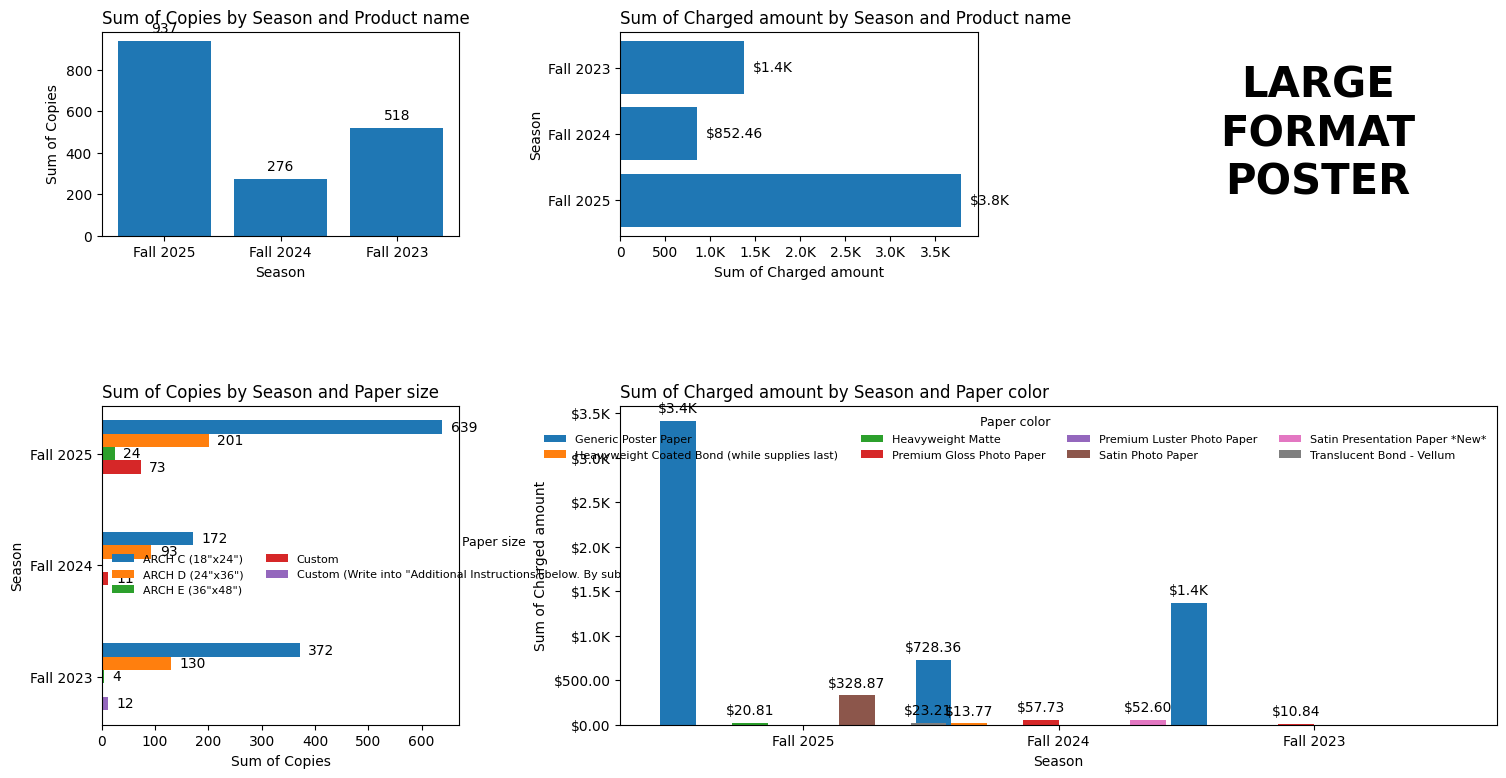

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

FILE_PATH = "Copy of Papercut_orders-Fall_2023_2024_2025_merged.xlsx"
SHEET_NAME = "All_Fall"
PRODUCT = "Large-Format Poster"

# ---------------- helpers ----------------
def clean_currency(series: pd.Series) -> pd.Series:
    s = (series.astype(str)
         .str.replace("$", "", regex=False)
         .str.replace(",", "", regex=False)
         .str.strip())
    return pd.to_numeric(s, errors="coerce")

def season_year(s):
    try:
        return int(str(s).split()[-1])
    except:
        return -1

def fmt_k(x):
    x = float(x)
    return f"{int(x)}" if abs(x) < 1000 else f"{x/1000:.1f}K"

def fmt_money(x):
    x = float(x)
    return f"${x:,.2f}" if abs(x) < 1000 else f"${x/1000:.1f}K"

def label_bars_vertical(ax, money=False):
    for r in ax.patches:
        h = r.get_height()
        if h == 0:
            continue
        txt = fmt_money(h) if money else f"{int(h)}"
        ax.annotate(
            txt,
            (r.get_x() + r.get_width()/2, h),
            ha="center", va="bottom",
            xytext=(0, 4), textcoords="offset points"
        )

def label_bars_horizontal(ax, money=False):
    for r in ax.patches:
        w = r.get_width()
        if w == 0:
            continue
        txt = fmt_money(w) if money else f"{int(w)}"
        ax.annotate(
            txt,
            (w, r.get_y() + r.get_height()/2),
            ha="left", va="center",
            xytext=(6, 0), textcoords="offset points"
        )

def grouped_barh(ax, pivot_df, title, xlabel, ylabel, legend_title, season_order):
    pivot_df = pivot_df.reindex(season_order, fill_value=0)
    seasons = pivot_df.index.astype(str).tolist()
    cols = pivot_df.columns.astype(str).tolist()

    y = np.arange(len(seasons))
    m = len(cols)
    bar_h = 0.12 if m > 4 else 0.20
    offsets = np.linspace(-bar_h*(m-1)/2, bar_h*(m-1)/2, m)

    for off, col in zip(offsets, cols):
        vals = pivot_df[col].values
        bars = ax.barh(y + off, vals, height=bar_h, label=col)
        for b, v in zip(bars, vals):
            if v == 0:
                continue
            ax.annotate(
                f"{int(v)}",
                (v, b.get_y() + b.get_height()/2),
                ha="left", va="center",
                xytext=(6, 0), textcoords="offset points"
            )

    ax.set_yticks(y)
    ax.set_yticklabels(seasons)
    ax.invert_yaxis()
    ax.set_title(title, loc="left")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=legend_title, frameon=False, fontsize=8, title_fontsize=9, ncols=2)

def grouped_barv(ax, pivot_df, title, xlabel, ylabel, legend_title, season_order, money=False):
    pivot_df = pivot_df.reindex(season_order, fill_value=0)
    seasons = pivot_df.index.astype(str).tolist()
    cols = pivot_df.columns.astype(str).tolist()

    x = np.arange(len(seasons))
    m = len(cols)
    width = 0.14 if m > 6 else 0.20

    for i, col in enumerate(cols):
        vals = pivot_df[col].values
        ax.bar(x + (i - (m-1)/2)*width, vals, width=width, label=col)

    label_bars_vertical(ax, money=money)
    ax.set_xticks(x)
    ax.set_xticklabels(seasons)
    ax.set_title(title, loc="left")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=legend_title, frameon=False, fontsize=8, title_fontsize=9, ncols=4)

# ---------------- load + clean ----------------
df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)

need = ["Season", "Product name", "Copies", "Charged amount", "Paper size", "Paper color"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in file: {missing}")

df["Copies"] = pd.to_numeric(df["Copies"], errors="coerce").fillna(0)
df["Charged amount"] = clean_currency(df["Charged amount"]).fillna(0)

lfp = df[df["Product name"].astype(str).str.strip() == PRODUCT].copy()

# season order like screenshot (Fall 2025, Fall 2023, Fall 2024)
season_order = sorted(lfp["Season"].dropna().unique(), key=season_year, reverse=True)

# ---------------- aggregations ----------------
copies_by_season = lfp.groupby("Season")["Copies"].sum().reindex(season_order, fill_value=0)
amt_by_season = lfp.groupby("Season")["Charged amount"].sum().reindex(season_order, fill_value=0)

paper_size_pivot = (lfp.groupby(["Season", "Paper size"])["Copies"].sum()
                    .unstack(fill_value=0).reindex(season_order, fill_value=0))

paper_color_amt_pivot = (lfp.groupby(["Season", "Paper color"])["Charged amount"].sum()
                         .unstack(fill_value=0).reindex(season_order, fill_value=0))

# optional: paper size order like your other visuals
preferred_sizes = ['ARCH C (18"x24")', 'ARCH D (24"x36")', 'ARCH E (36"x48")', 'Custom']
ps_cols = [s for s in preferred_sizes if s in paper_size_pivot.columns]
ps_cols += [s for s in paper_size_pivot.columns if s not in ps_cols]
paper_size_pivot = paper_size_pivot[ps_cols]

# ---------------- layout like screenshot ----------------
fig = plt.figure(figsize=(18, 9))
gs = fig.add_gridspec(2, 3, height_ratios=[0.8, 1.25], wspace=0.45, hspace=0.65)

ax1 = fig.add_subplot(gs[0, 0])      # copies by season
ax2 = fig.add_subplot(gs[0, 1])      # amount by season (horizontal)
axTitle = fig.add_subplot(gs[0, 2])  # title box
ax3 = fig.add_subplot(gs[1, 0])      # copies by season + paper size
ax4 = fig.add_subplot(gs[1, 1:3])    # amount by season + paper color

# Chart 1: Copies by Season
ax1.bar(copies_by_season.index.astype(str), copies_by_season.values)
ax1.set_title("Sum of Copies by Season and Product name", loc="left")
ax1.set_xlabel("Season")
ax1.set_ylabel("Sum of Copies")
label_bars_vertical(ax1, money=False)

# Chart 2: Charged amount by Season (horizontal)
ax2.barh(amt_by_season.index.astype(str), amt_by_season.values)
ax2.set_title("Sum of Charged amount by Season and Product name", loc="left")
ax2.set_xlabel("Sum of Charged amount")
ax2.set_ylabel("Season")
ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_k(x)))
# labels
for r in ax2.patches:
    w = r.get_width()
    if w == 0:
        continue
    ax2.annotate(fmt_money(w),
                 (w, r.get_y() + r.get_height()/2),
                 ha="left", va="center",
                 xytext=(6, 0), textcoords="offset points")

# Title box
axTitle.axis("off")
axTitle.text(0.5, 0.5, "LARGE\nFORMAT\nPOSTER",
             ha="center", va="center",
             fontsize=30, fontweight="bold")

# Chart 3: Copies by Season and Paper size (grouped horizontal)
grouped_barh(
    ax3, paper_size_pivot,
    title="Sum of Copies by Season and Paper size",
    xlabel="Sum of Copies",
    ylabel="Season",
    legend_title="Paper size",
    season_order=season_order
)

# Chart 4: Charged amount by Season and Paper color (grouped vertical)
grouped_barv(
    ax4, paper_color_amt_pivot,
    title="Sum of Charged amount by Season and Paper color",
    xlabel="Season",
    ylabel="Sum of Charged amount",
    legend_title="Paper color",
    season_order=season_order,
    money=True
)
ax4.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_money(x)))

plt.tight_layout()
plt.show()
